<a href="https://colab.research.google.com/github/mcatrinque/areas-cep-mg/blob/main/analise_area_cep_mg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Representação Geométrica das Áreas de CEP do Estado de Minas Gerais


O notebook a seguir, apresenta uma análise das bases de dados contendo o registro de endereços residenciais e comerciais do Estado de Minas Gerais e tem como objetivo gerar uma nova base com representações das áreas de CEP, a partir do agrupamento desses endereços. Segue abaixo, o link de acesso à base gerada:

**Download**: [Áreas de CEPs de MG](https://drive.google.com/file/d/1ULHcGVf3r3I93x9_ZjQ4BKSe8yiWfuXm/view?usp=sharing)

##Adicionando Bibliotecas

In [1]:
!pip install geopandas
from google.colab import files
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pyproj
import missingno as msno
import seaborn as sns
import plotly.express as px

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Importando Base de Dados

As bases contendo as unidades residenciais e comerciais de Minas gerais foram obtidas a partir de um repositório contido no [OpenAddresses](https://batch.openaddresses.io/data) e do sistema [BHMAP - PBH](http://bhmap.pbh.gov.br/v2/mapa/idebhgeo), fornecido pela Prefeitura de Belo Horizonte. Os limites territoriais foram coletados junto ao [Portal de Mapas - IBGE](https://portaldemapas.ibge.gov.br/portal.php).

Carregando tabelas com os registros de unidades residenciais e comerciais referentes a Belo Horizonte e Minas Gerais

In [2]:
path = '/content/'
!gdown "1ggh_PcHpAYUz-z1GNlKUG1SYKWS5OKh5"
!gdown "1PNr1UECAIGAbuRA9hn3BYwiSy3WHIa5p"

Downloading...
From: https://drive.google.com/uc?id=1ggh_PcHpAYUz-z1GNlKUG1SYKWS5OKh5
To: /content/unidades
100% 1.13G/1.13G [00:04<00:00, 253MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PNr1UECAIGAbuRA9hn3BYwiSy3WHIa5p
To: /content/unidades_bh
100% 95.0M/95.0M [00:00<00:00, 196MB/s]


### Unidades Residenciais e Comerciais - Minas Gerais

In [3]:
unidades_mg = pd.read_csv('unidades', sep=';', )
unidades_mg.drop('unit', axis=1, inplace=True)
unidades_mg.drop('district', axis=1, inplace=True)
unidades_mg.drop('cod_unidade', axis=1, inplace=True)
unidades_mg.drop('id', axis=1, inplace=True)
unidades_mg.rename(columns={'number':'Numero', 'street': 'Rua', 'city':'Cidade', 'region':'UF', 'postcode':'CEP'}, inplace=True)
unidades_mg.head()

,distancia,ogc_fid,hash,Numero,Rua,Cidade,UF,CEP,wkb_geometry
0,0.132457,1,241967d28ddd6943,375,AVENIDA JOSE ESTEVES BORGES,Abadia dos Dourados,MG,38540-000,010100002042120000FA83DCA051B347C04EB6813B507D...
1,0.132457,2,fdb87216b827362d,241,AVENIDA JOSE ESTEVES BORGES,Abadia dos Dourados,MG,38540-000,010100002042120000FA83DCA051B347C04EB6813B507D...
2,0.132457,3,b00de4ecf671ccb2,225,AVENIDA JOSE ESTEVES BORGES,Abadia dos Dourados,MG,38540-000,010100002042120000FA83DCA051B347C04EB6813B507D...
3,0.132457,4,ea24966be48ddaf1,219,AVENIDA JOSE ESTEVES BORGES,Abadia dos Dourados,MG,38540-000,010100002042120000FA83DCA051B347C04EB6813B507D...
4,0.134399,6,bdc9aa2327a071ca,20,RUA JOSE TOMAZ DA CUNHA,Abadia dos Dourados,MG,38540-000,010100002042120000F9A46EC218B347C0D9092FC1A97D...


### Unidades Residenciais e Comerciais - Belo Horizonte

In [4]:
unidades_bh = pd.read_csv('unidades_bh', sep=';')
unidades_bh.rename(columns={'number':'Numero', 'street': 'Rua', 'unit':'Unidade', 'postcode':'CEP'}, inplace=True)
unidades_bh.head()

,Rua,Numero,Unidade,CEP,hash,ogc_fid,distancia,wkb_geometry
0,AVENIDA AFONSO PENA,3031,APARTAMENTO 51,30130-008,aed2de0f4bb1b626,533112,0.004529,0101000020421200004628B682A6F645C05E8C37E801F0...
1,AVENIDA AFONSO PENA,3031,APARTAMENTO 52,30130-008,29eaf1ffa950d168,533113,0.004529,0101000020421200004628B682A6F645C05E8C37E801F0...
2,AVENIDA AFONSO PENA,3031,APARTAMENTO 41,30130-008,b8c4078e882931ed,533114,0.004529,0101000020421200004628B682A6F645C05E8C37E801F0...
3,AVENIDA AFONSO PENA,3031,APARTAMENTO 42,30130-008,9d0fc28ad8dd4f1e,533115,0.004529,0101000020421200004628B682A6F645C05E8C37E801F0...
4,AVENIDA AFONSO PENA,3031,APARTAMENTO 31,30130-008,2a0d2e9888b185e2,533116,0.004529,0101000020421200004628B682A6F645C05E8C37E801F0...


## Análises e Observações das Bases de Dados

Foi realizada uma breve análise da qualidade e dos tipos de dados relativos aos endereços de residências e comércios no estado de Minas Gerais.

### Análise da base de dados de Minas Gerais

Verificando os Tipos de dados da base

In [5]:
unidades_mg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6741881 entries, 0 to 6741880
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   distancia     float64
 1   ogc_fid       int64  
 2   hash          object 
 3   Numero        object 
 4   Rua           object 
 5   Cidade        object 
 6   UF            object 
 7   CEP           object 
 8   wkb_geometry  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 462.9+ MB


Avaliando atributos de acordo com a quantidade de registros vazios 

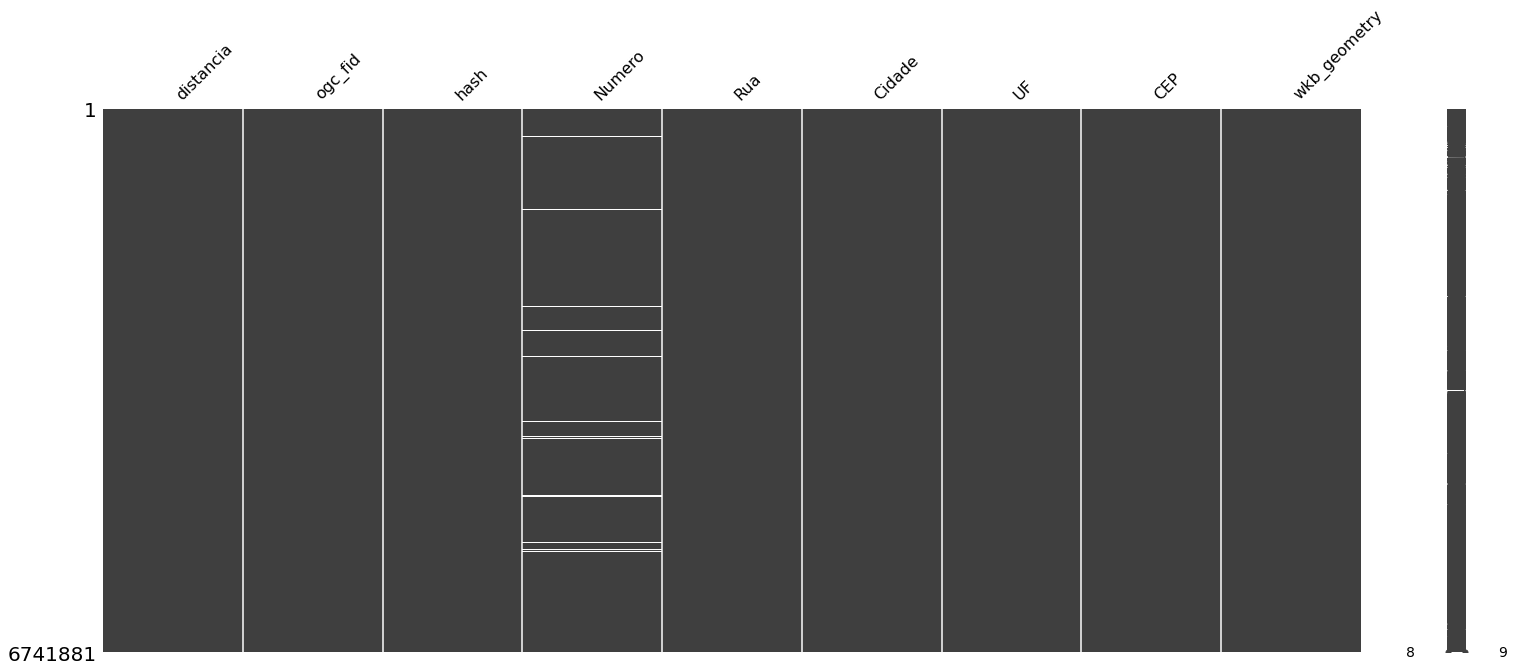

In [6]:
msno.matrix(unidades_mg)

### Análise da base de dados de Belo Horizonte

Verificando os Tipos de dados da base

In [7]:
unidades_bh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676408 entries, 0 to 676407
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Rua           676408 non-null  object 
 1   Numero        676125 non-null  object 
 2   Unidade       387097 non-null  object 
 3   CEP           676408 non-null  object 
 4   hash          676408 non-null  object 
 5   ogc_fid       676408 non-null  int64  
 6   distancia     676408 non-null  float64
 7   wkb_geometry  676408 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 41.3+ MB


Avaliando atributos de acordo com a quantidade de registros vazios 

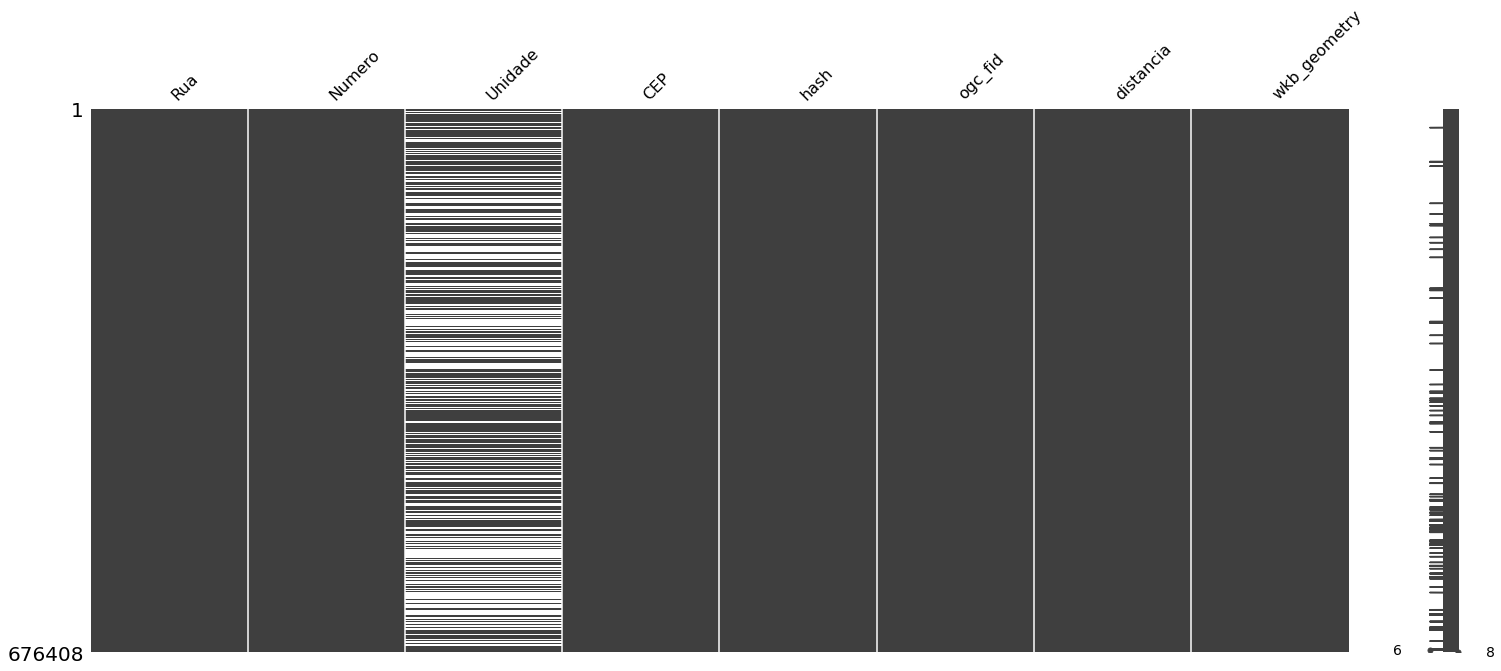

In [8]:
msno.matrix(unidades_bh)

##Definições de Área Extraídas das Bases Anteriores

######Representação das Áreas de CEP - Minas Gerais

In [9]:
!gdown "1wzhm433XVQjMNXfykrIVx1SRvgJKIzEd"
!gdown "1YXx2oIixYeMZoeOiE8CXCwXUjiHrIJOb"
!gdown "1NxNR_yQ7IdzUnPq4Whkr8O-nhmiDuA1-"
!gdown "1nrnyH7o1MA7FTbKetIY8qgPDz_etZrXE"

Downloading...
From: https://drive.google.com/uc?id=1wzhm433XVQjMNXfykrIVx1SRvgJKIzEd
To: /content/br_mg_poligonos_ceps.shp
100% 34.9M/34.9M [00:00<00:00, 155MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YXx2oIixYeMZoeOiE8CXCwXUjiHrIJOb
To: /content/br_mg_poligonos_ceps.dbf
100% 778k/778k [00:00<00:00, 135MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NxNR_yQ7IdzUnPq4Whkr8O-nhmiDuA1-
To: /content/br_mg_poligonos_ceps.shx
100% 311k/311k [00:00<00:00, 116MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nrnyH7o1MA7FTbKetIY8qgPDz_etZrXE
To: /content/br_mg_poligonos_ceps.prj
100% 151/151 [00:00<00:00, 231kB/s]


###Limites dos Municipios MG

In [10]:
!gdown "10etKZd9KUV47m_wm9EnqsFGXLp0Lc2dv"
!gdown "1WExkYI1i6JrUw_sMkx2hGqzNwgz5wdsL"
!gdown "1O1Gja2X7CcbUQeuMp3Qa3yVlgRVXoD9O"
!gdown "18Do2b9uuY3MON8Z7ace_wF0erEIB7kUH"

Downloading...
From: https://drive.google.com/uc?id=10etKZd9KUV47m_wm9EnqsFGXLp0Lc2dv
To: /content/br_mg_limites_municipios.dbf
100% 207k/207k [00:00<00:00, 65.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WExkYI1i6JrUw_sMkx2hGqzNwgz5wdsL
To: /content/br_mg_limites_municipios.shp
100% 48.5M/48.5M [00:00<00:00, 193MB/s]
Downloading...
From: https://drive.google.com/uc?id=1O1Gja2X7CcbUQeuMp3Qa3yVlgRVXoD9O
To: /content/br_mg_limites_municipios.shx
100% 6.92k/6.92k [00:00<00:00, 11.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=18Do2b9uuY3MON8Z7ace_wF0erEIB7kUH
To: /content/br_mg_limites_municipios.prj
100% 151/151 [00:00<00:00, 250kB/s]


###Representação das Áreas de CEP - Belo Horizonte

In [11]:
!gdown "1aqnDkgEKC45QmovK0Hk1costnSYSuPsS"
!gdown "1C1iKbh06HTI8sLcYxBgjuwmoohtTfiFe"
!gdown "1WP-myPEeiCz6-tTaViMpXEafW4txIs0X"
!gdown "1pr3eUz86nt_0ysECgxBDqXjR8u-jrrbp"
!gdown "1-SprTOc5UVaOG7sxN_-NIe3dYHNMSd6t"
!gdown "1-JkUFi62EG30m15GOOYCkukVWSPWpWC_"
!gdown "1-PyRo0YZe3HycMCnc4FRJOwRZI_Ceq0B"
!gdown "1-KV1kFT7esynqfeU8f_MxprYR4fHDuhp"

Downloading...
From: https://drive.google.com/uc?id=1aqnDkgEKC45QmovK0Hk1costnSYSuPsS
To: /content/br_mg_bh_poligonos_ceps_concavos.prj
100% 151/151 [00:00<00:00, 260kB/s]
Downloading...
From: https://drive.google.com/uc?id=1C1iKbh06HTI8sLcYxBgjuwmoohtTfiFe
To: /content/br_mg_bh_poligonos_ceps_concavos.dbf
100% 287k/287k [00:00<00:00, 85.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WP-myPEeiCz6-tTaViMpXEafW4txIs0X
To: /content/br_mg_bh_poligonos_ceps_concavos.shx
100% 115k/115k [00:00<00:00, 46.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pr3eUz86nt_0ysECgxBDqXjR8u-jrrbp
To: /content/br_mg_bh_poligonos_ceps_concavos.shp
100% 6.55M/6.55M [00:00<00:00, 192MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-SprTOc5UVaOG7sxN_-NIe3dYHNMSd6t
To: /content/br_mg_bh_poligonos_ceps_convexos.shp
100% 2.98M/2.98M [00:00<00:00, 185MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-JkUFi62EG30m15GOOYCkukVWSPWpWC_
To: /content/br_mg_bh_poligonos_ceps_con

###Limites Regionais Belo Horizonte

In [12]:
!gdown "1F2-9jbpOPKttjh552O769EzMsqD7P1Ve"
!gdown "1km-XOlaonfsGmmkZqoyTCxgmW-ToqlgL"
!gdown "1splo5MNUf1vltEOESZOoi3CO1rdfu-sH"
!gdown "1sr1VLaEcbJ3OO-KNW2JeGXqwGWJ6bcE0"

Downloading...
From: https://drive.google.com/uc?id=1F2-9jbpOPKttjh552O769EzMsqD7P1Ve
To: /content/br_mg_bh_limites_regionais.shp
100% 411k/411k [00:00<00:00, 114MB/s]
Downloading...
From: https://drive.google.com/uc?id=1km-XOlaonfsGmmkZqoyTCxgmW-ToqlgL
To: /content/br_mg_bh_limites_regionais.shx
100% 108/108 [00:00<00:00, 178kB/s]
Downloading...
From: https://drive.google.com/uc?id=1splo5MNUf1vltEOESZOoi3CO1rdfu-sH
To: /content/br_mg_bh_limites_regionais.dbf
100% 229/229 [00:00<00:00, 385kB/s]
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1sr1VLaEcbJ3OO-KNW2JeGXqwGWJ6bcE0 



## Coleta e Tratamento de Dados
Os shapefiles foram gerados a partir do agrupamento de unidades residenciais e comerciais, em função do cep, da distância dos pontos de cada *cluster* para o seu centróide e da área corresponde ao território do municpios que possuem um único CEP. Os pontos georeferenciados do estado de Minas Gerais e de Belo Horizonte foram obtidos a partir das bases de dados importadas. A partir dos pontos fornecidos pela base e tratados pelo processo descrito, foi possível estimar um envoltório convexo que determina-se os limites de área dos CEPs que não eram equivalente a área do município. Em busca de suavizar o contorno das formas geométricas obtidas, foi realizado um processo de delimitação da área de CEPs por envoltório côncavo, aplicado apenas para os CEPs pertencentes à cidade de Belo Horizonte.

### Agrupando as unidades por CEP e Cidade

###Dados Relacionados as Áreas de CEP - Minas Gerais

In [13]:
# project GeoPandas dataframe
mg_area_cep = gpd.read_file(path + 'br_mg_poligonos_ceps.shp')
mg_area_cep.drop('id', axis=1, inplace=True)
mg_area_cep.to_crs(pyproj.CRS.from_epsg(4674), inplace=True)
mg_area_cep.rename(columns={'postcode':'CEP', 'city':'Cidade'}, inplace=True)
#Generate coordenates to plot 
#mg_area_cep['Coordenadas'] = mg_area_cep['geometry'].centroid


In [14]:
#Join units by postcode and count. After this, merging result into postcode geometry dataframes
mg_area_cep = pd.merge(unidades_mg.groupby(['CEP', 'Cidade']).size().rename('QTD_Unidades').reset_index(), mg_area_cep, on=['CEP'], how='left')
mg_area_cep = mg_area_cep.dropna()
#Fit count colunmn to nunmeric type
mg_area_cep['QTD_Unidades'] = pd.to_numeric(mg_area_cep['QTD_Unidades'])
#Transform merged DataFrame into a GeoDataFrame
mg_area_cep = gpd.GeoDataFrame(mg_area_cep, geometry='geometry')
#mg_area_cep.set_index('CEP', inplace=True)
mg_area_cep.head()

,CEP,Cidade,QTD_Unidades,geometry
0,30107-970,Belo Horizonte,74,"POLYGON ((-43.93719 -19.82030, -43.93913 -19.8..."
3,30110-012,Belo Horizonte,24,"POLYGON ((-43.92042 -19.92249, -43.92463 -19.9..."
4,30110-013,Belo Horizonte,36,"POLYGON ((-43.91919 -19.92237, -43.91999 -19.9..."
5,30110-017,Belo Horizonte,72,"POLYGON ((-43.92015 -19.92776, -43.91997 -19.9..."
6,30110-018,Belo Horizonte,22,"POLYGON ((-43.92038 -19.92731, -43.92059 -19.9..."


In [15]:
mg_area_cep.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 29990 entries, 0 to 31702
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   CEP           29990 non-null  object  
 1   Cidade        29990 non-null  object  
 2   QTD_Unidades  29990 non-null  int64   
 3   geometry      29990 non-null  geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 1.1+ MB


###Estatísticas relacionadas à quantidade de unidades associadas a cada CEP de Minas Gerais:

In [16]:
mg_area_cep.describe()

,QTD_Unidades
count,29990.000000
mean,222.526709
std,1260.795504
min,3.000000
25%,32.000000
50%,59.000000
75%,109.000000
max,46309.000000


###Visualização da distribuição das unidades por CEP em Belo Horizonte

In [17]:
#You can see the distribution of residential and commercial units
px.violin(
    mg_area_cep,
    x = "QTD_Unidades",
    #draw box plot inside violin
    box = True,
    #draw all individual points 
    points = "all" 
)

###Dados Relacionados as Áreas de CEP - Belo Horizonte

In [18]:
# project GeoPandas dataframe
bh_area_cep = gpd.read_file(path + 'br_mg_bh_poligonos_ceps_concavos.shp')
bh_area_cep.to_crs(pyproj.CRS.from_epsg(4674), inplace=True)
bh_area_cep.drop('id', axis=1, inplace=True)
bh_area_cep.rename(columns={'cep':'CEP'}, inplace=True)

In [19]:
bh_area_cep = pd.merge(unidades_bh.groupby(['CEP']).size().rename('QTD_Unidades').reset_index(), bh_area_cep, on=['CEP'], how='right')
#Fit count colunmn to nunmeric type
bh_area_cep['QTD_Unidades'] = pd.to_numeric(bh_area_cep['QTD_Unidades'])
#Transform merged DataFrame into a GeoDataFrame
bh_area_cep = gpd.GeoDataFrame(bh_area_cep, geometry='geometry')
#bh_area_cep.set_index('CEP', inplace=True)
bh_area_cep.head()

,CEP,QTD_Unidades,geometry
0,31744-134,NaN,"POLYGON ((-43.94817 -19.82529, -43.94838 -19.8..."
1,31748-550,NaN,"POLYGON ((-43.92594 -19.80153, -43.92602 -19.8..."
2,30860-280,NaN,"POLYGON ((-44.00601 -19.91061, -44.00584 -19.9..."
3,30260-090,NaN,"POLYGON ((-43.91679 -19.92123, -43.91687 -19.9..."
4,31130-230,69.0,"POLYGON ((-43.94960 -19.88662, -43.94983 -19.8..."


In [20]:
bh_area_cep.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 14363 entries, 0 to 14362
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   CEP           14363 non-null  object  
 1   QTD_Unidades  5968 non-null   float64 
 2   geometry      14363 non-null  geometry
dtypes: float64(1), geometry(1), object(1)
memory usage: 448.8+ KB


###Estatísticas relacionadas à quantidade de unidades associadas a cada CEP de Belo Horizonte:

In [21]:
bh_area_cep.describe()

,QTD_Unidades
count,5968.000000
mean,109.696548
std,113.005080
min,3.000000
25%,41.000000
50%,75.000000
75%,137.000000
max,1719.000000


###Visualização da distribuição das unidades por CEP em Belo Horizonte

In [22]:
#You can see the distribution of residential and commercial units
px.violin(
    bh_area_cep,
    x = "QTD_Unidades",
    #draw box plot inside violin
    box = True,
    #draw all individual points 
    points = "all" 
)

In [23]:
lim_regional = gpd.read_file(path + 'br_mg_bh_limites_regionais.shp')
lim_regional.rename(columns={'AREA_KM2':'Area', 'NOME':'Regiao'}, inplace=True)
lim_regional.drop('ID_LM', axis=1, inplace=True)
lim_regional.drop('PERIMETR_M', axis=1, inplace=True)
lim_regional.head()

,Area,geometry
0,330.23,"POLYGON ((609866.632 7789584.944, 609865.420 7..."



## Visualização das Áreas Geradas

Base de dados para definir os limites municipais, auxiliando na visualização posterior das geometrias de CEP.

In [24]:
lim_municipal = gpd.read_file(path + 'br_mg_limites_municipios.shp')
lim_municipal.rename(columns={'NOME':'Cidade', 'AREA':'Area', 'GEOCODIGO' : 'Geocodigo'}, inplace=True)
lim_municipal.drop('ANODEREFER', axis=1, inplace=True)
lim_municipal.drop('LEICRIACAO', axis=1, inplace=True)
lim_municipal.head()

,Cidade,Geocodigo,Area,geometry
0,Munhoz,3143807,190.72,"LINESTRING (-46.40541 -22.61895, -46.40555 -22..."
1,Contagem,3118601,194.38,"LINESTRING (-44.02628 -19.90228, -44.02629 -19..."
2,Belo Horizonte,3106200,330.23,"LINESTRING (-43.95019 -19.98793, -43.95019 -19..."
3,Confins,3117876,41.67,"LINESTRING (-43.94228 -19.65750, -43.94232 -19..."
4,Lagoa Santa,3137601,229.45,"LINESTRING (-43.96842 -19.59981, -43.96862 -19..."


O que se pode observar depois das operações de tratamento e manipulação dos dados coletados, resultou em um arquivo, no formato shapefile, disponível no [Google Drive](https://drive.google.com/drive/folders/1GLgAKU3Ejle7BIYV8CYyG_siGLirDMgB?usp=sharing). Em relação aos polígonos gerados para a representação de área dos CEPs, é possível identificar os seguintes fenômenos:
*   A forma dos polígono em cidades com apenas um cep, pode ser definida pelos limites territoriais do município;
*   Cidades com alta concentração de CEPs, tendem a gerar geometrias disformes;
*   O formato dos CEPs nos grandes centros urbanos, tende a se aproximar do traçado de suas ruas.

Abaixo, seguem as visualizações que corroboram as inferências citadas:

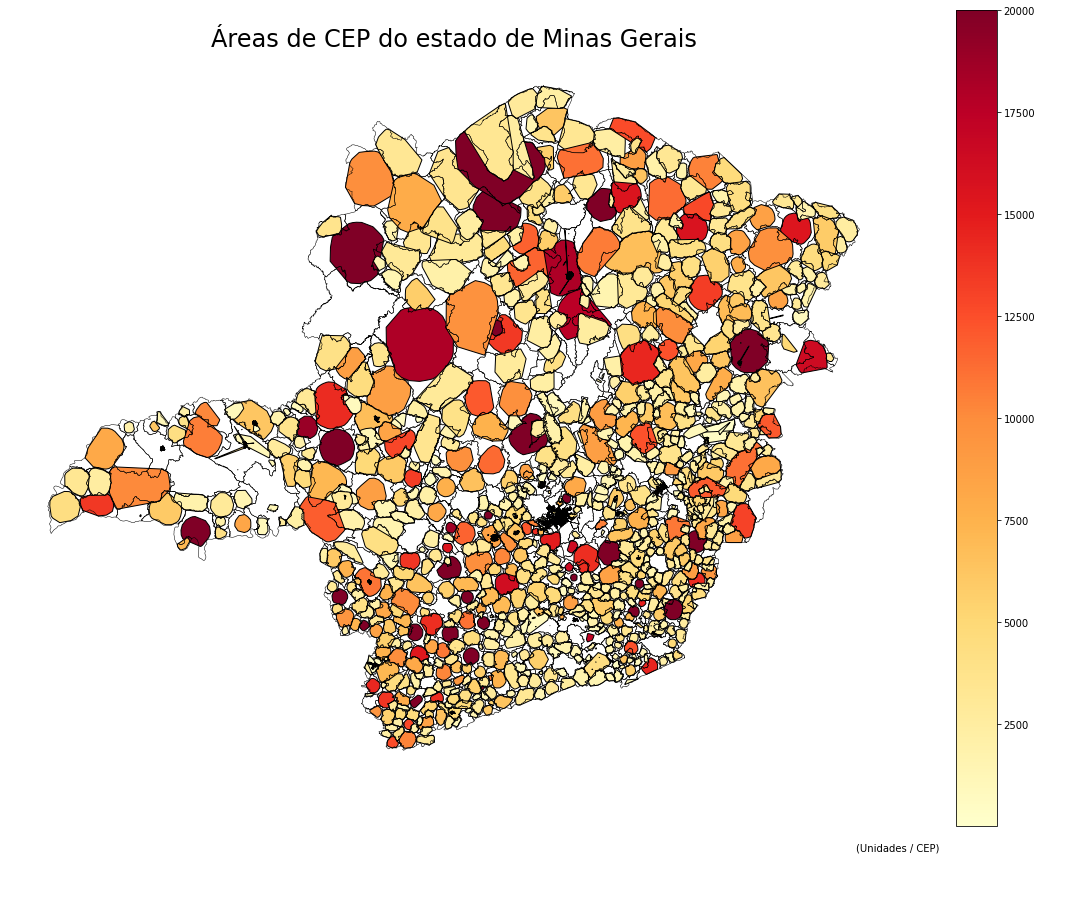

In [25]:
fig, gax = plt.subplots(figsize = (20,15))
plt.title("Áreas de CEP do estado de Minas Gerais", fontsize=24)
lim_municipal.plot(ax=gax,
                   edgecolor='black',
                   linewidth=0.5)
mg_area_cep.plot(
    ax=gax, 
    edgecolor='black', 
    column='QTD_Unidades', 
    legend=True, 
    cmap='YlOrRd',
    vmin=1, vmax=20000
    )
gax.annotate('(Unidades / CEP)',xy=(0.8, 0.06),  xycoords='figure fraction')

plt.axis('off')

#labeling the map with the cities
#for x, y, label in zip(mg_area_cep['Coordenadas'].x, mg_area_cep['Coordenadas'].y, mg_area_cep['Cidade']):
#    gax.annotate(label, xy=(x,y), xytext=(4,4), textcoords='offset points')

plt.show()

In [26]:
mg_bh_area_cep = mg_area_cep.loc[mg_area_cep['Cidade'] == 'Belo Horizonte']
mg_bh_area_cep

,CEP,Cidade,QTD_Unidades,geometry
0,30107-970,Belo Horizonte,74,"POLYGON ((-43.93719 -19.82030, -43.93913 -19.8..."
3,30110-012,Belo Horizonte,24,"POLYGON ((-43.92042 -19.92249, -43.92463 -19.9..."
4,30110-013,Belo Horizonte,36,"POLYGON ((-43.91919 -19.92237, -43.91999 -19.9..."
5,30110-017,Belo Horizonte,72,"POLYGON ((-43.92015 -19.92776, -43.91997 -19.9..."
6,30110-018,Belo Horizonte,22,"POLYGON ((-43.92038 -19.92731, -43.92059 -19.9..."
...,...,...,...,...
6204,31998-570,Belo Horizonte,53,"POLYGON ((-43.86771 -19.83269, -43.86791 -19.8..."
6205,31998-595,Belo Horizonte,17,"POLYGON ((-43.86729 -19.83122, -43.86767 -19.8..."
6206,31998-598,Belo Horizonte,31,"POLYGON ((-43.86816 -19.82966, -43.86827 -19.8..."
6207,31998-616,Belo Horizonte,47,"POLYGON ((-43.86917 -19.82874, -43.86910 -19.8..."


In [27]:
# project GeoPandas dataframe
bh_area_cep_cv = gpd.read_file(path + 'br_mg_bh_poligonos_ceps_convexos.shp')
bh_area_cep_cv.to_crs(pyproj.CRS.from_epsg(4674), inplace=True)
bh_area_cep_cv.set_index('CEP', inplace=True)
bh_area_cep_cv.head()

,geometry
CEP,
31060-390,"POLYGON ((-43.90663 -19.89777, -43.90680 -19.8..."
30640-060,"POLYGON ((-44.02445 -19.97684, -44.02445 -19.9..."
30620-180,"POLYGON ((-43.99782 -19.98924, -43.99811 -19.9..."
30622-060,"POLYGON ((-43.99272 -19.98516, -43.99290 -19.9..."
30620-730,"POLYGON ((-43.99813 -19.98586, -43.99810 -19.9..."


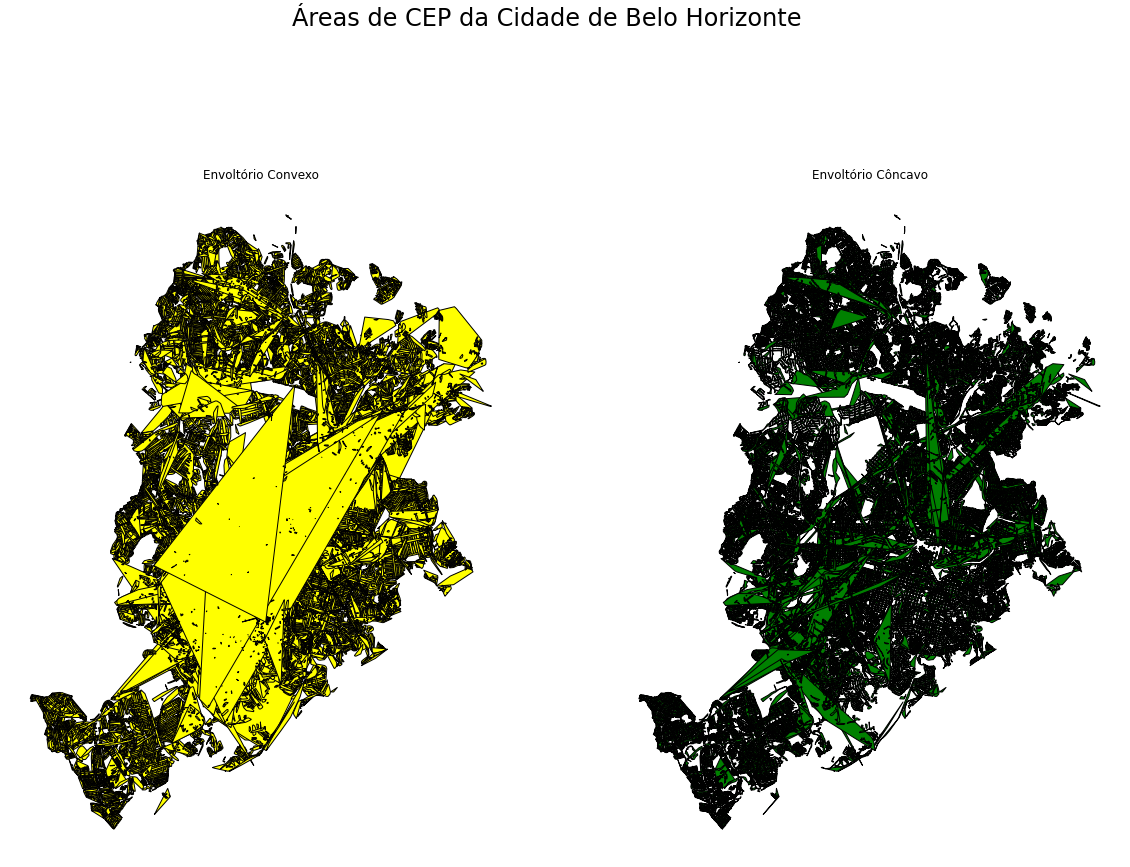

In [28]:
fig, gax = plt.subplots(ncols=2, figsize = (20,15))
fig.suptitle("Áreas de CEP da Cidade de Belo Horizonte", fontsize=24)

gax[0].set_title("Envoltório Convexo", fontsize=12)
bh_area_cep_cv.plot(ax=gax[0],
                    edgecolor='black',
                    color='yellow',
                    linewidth=1)
gax[0].axis('off')

gax[1].set_title("Envoltório Côncavo", fontsize=12)
bh_area_cep.plot(ax=gax[1],
                 edgecolor='black',
                 color='green',
                 linewidth=1)
gax[1].axis('off')

plt.show()

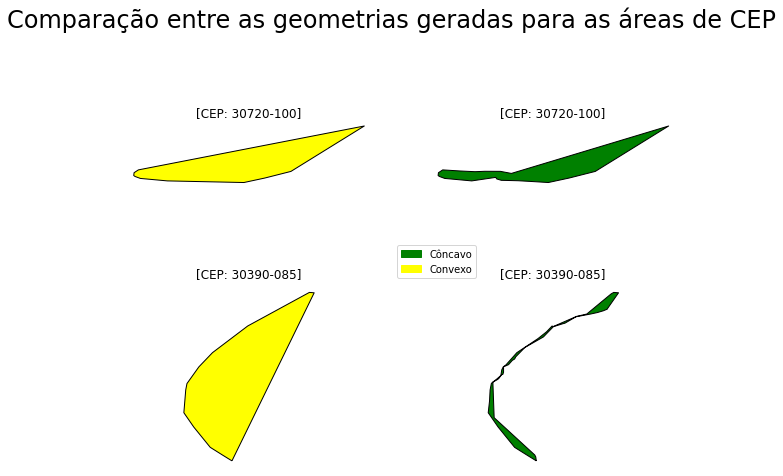

In [29]:
fig, gax = plt.subplots(ncols=2, nrows=2, figsize = (10,7.5))
fig.suptitle("Comparação entre as geometrias geradas para as áreas de CEP", fontsize=24)
gax[0,0].set_title("[CEP: 30720-100]", fontsize=12)
bh_area_cep.set_index('CEP')
bh_area_cep_cv.loc[['30720-100'],'geometry'].plot(ax=gax[0,0],
                   edgecolor='black',
                   color='yellow',
                   linewidth=1)
gax[0,0].axis('off')

gax[0,1].set_title("[CEP: 30720-100]", fontsize=12)
bh_area_cep.set_index('CEP').loc[['30720-100'],'geometry'].plot(ax=gax[0,1],
                   edgecolor='black',
                   color='green',
                   label="sine",
                   linewidth=1)
gax[0,1].axis('off')

gax[1,0].set_title("[CEP: 30390-085]", fontsize=12)
bh_area_cep.set_index('CEP')
bh_area_cep_cv.loc[['30390-085'],'geometry'].plot(ax=gax[1,0],
                   edgecolor='black',
                   color='yellow',
                   linewidth=1)
gax[1,0].axis('off')

gax[1,1].set_title("[CEP: 30390-085]", fontsize=12)
bh_area_cep.set_index('CEP').loc[['30390-085'],'geometry'].plot(ax=gax[1,1],
                   edgecolor='black',
                   color='green',
                   label="sine",
                   linewidth=1)
gax[1,1].axis('off')

green_patch = mpatches.Patch(color='green', label='Côncavo')
yellow_patch = mpatches.Patch(color='yellow', label='Convexo')

plt.legend(handles=[green_patch, yellow_patch], bbox_to_anchor=(0, 1), loc='lower right', ncol=1)

plt.show()

## Resultados

Como resultado da criação de uma representação de áreas de CEP para o Estado de Minas gerais, foi gerada uma base de dados fruto da junção entre a representação de áreas de CEP do Estado de Minas Gerais, baseadas em uma delimitação por meio de envoltório convexo, e as áreas de CEP de Belo Horizonte, suavizadas por um processo envoltório côncavo.

In [30]:
bh_area_cep['Cidade'] = 'Belo Horizonte'
bh_area_cep = bh_area_cep[['CEP', 'Cidade', 'QTD_Unidades', 'geometry']]
bh_area_cep = bh_area_cep.sort_values(by = 'QTD_Unidades')
bh_area_cep.head()

,CEP,Cidade,QTD_Unidades,geometry
6943,30140-160,Belo Horizonte,3.0,"POLYGON ((-43.93588 -19.93860, -43.93600 -19.9..."
11153,31255-120,Belo Horizonte,3.0,"POLYGON ((-43.95433 -19.87509, -43.95473 -19.8..."
10332,31365-060,Belo Horizonte,4.0,"POLYGON ((-43.99735 -19.86833, -43.99743 -19.8..."
11319,30810-620,Belo Horizonte,4.0,"POLYGON ((-43.99244 -19.89259, -43.99278 -19.8..."
12545,30730-710,Belo Horizonte,4.0,"POLYGON ((-43.98598 -19.90654, -43.98605 -19.9..."


In [31]:
mg_area_cep.drop(mg_area_cep[mg_area_cep['Cidade'] >= 'Belo Horizonte'].index, inplace = True)
mg_area_cep = mg_area_cep.append(bh_area_cep)
mg_area_cep = mg_area_cep.sort_values(by = 'QTD_Unidades')
mg_area_cep.head()

,CEP,Cidade,QTD_Unidades,geometry
6943,30140-160,Belo Horizonte,3.0,"POLYGON ((-43.93588 -19.93860, -43.93600 -19.9..."
11153,31255-120,Belo Horizonte,3.0,"POLYGON ((-43.95433 -19.87509, -43.95473 -19.8..."
10332,31365-060,Belo Horizonte,4.0,"POLYGON ((-43.99735 -19.86833, -43.99743 -19.8..."
11319,30810-620,Belo Horizonte,4.0,"POLYGON ((-43.99244 -19.89259, -43.99278 -19.8..."
28243,38440-044,Araguari,4.0,"POLYGON ((-48.18310 -18.64560, -48.18392 -18.6..."


In [32]:
mg_area_cep.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 15761 entries, 6943 to 14361
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   CEP           15761 non-null  object  
 1   Cidade        15761 non-null  object  
 2   QTD_Unidades  7366 non-null   float64 
 3   geometry      15761 non-null  geometry
dtypes: float64(1), geometry(1), object(2)
memory usage: 615.7+ KB


In [33]:
mg_area_cep.to_csv('areas_cep_mg.csv', encoding='utf-8')
#files.download('areas_cep_mg.csv')